# Coronavirus Tweets

## Install

In [1]:
pip install unidecode

## Libraries

In [2]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, GRU, Dropout
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.metrics import classification_report

from unidecode import unidecode
from nltk.corpus import stopwords
from nltk import FreqDist
from PIL import Image
import re
import stylecloud
import unicodedata
import nltk

In [3]:
# Stop words download
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Google


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

myfile = drive.CreateFile({'id': '1Lyfy9yKVWscKYf4d8MJojHO1BwUMz65A'})
myfile.GetContentFile('Corona_NLP_train.csv')

## Dataset

In [5]:
df = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [7]:
df["Day"] = [i.day for i in pd.to_datetime(df["TweetAt"])]
df["Month"] = [i.month for i in pd.to_datetime(df["TweetAt"])]
df.drop(columns = ["TweetAt"], inplace = True)

_Year will be eliminated because of all tweets being from 2020_

## Data Visualization

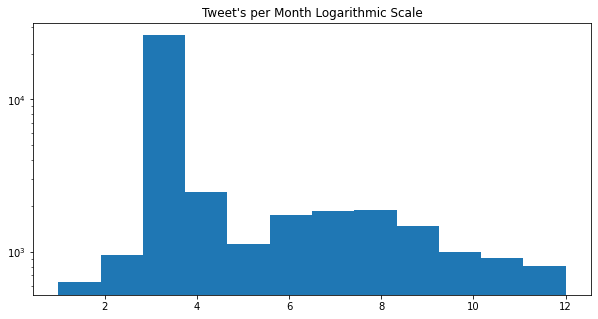

In [8]:
plt.figure(1, figsize=(10, 5))
plt.hist(df.Month, log = True, bins = 12)
plt.title("Tweet's per Month Logarithmic Scale")
plt.show()

_The number of tweets in march is so much larger than any other month, this is caused because in frebruary 29th the first person died of Coronavirus in the USA_

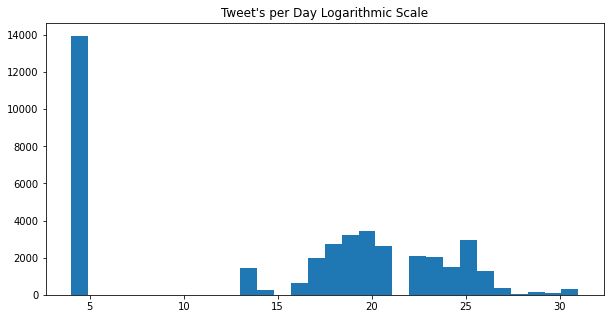

In [9]:
plt.figure(1, figsize=(10, 5))
plt.hist(df.Day, bins = 30)
plt.title("Tweet's per Day Logarithmic Scale")
plt.show()

_The number of tweets began to increase in march 13, this day president Trump declared a national emergency. Also there were more tweets than usual the 25 and 26 or march, this is caused by the United States leading the world in confirmed cases. And in april the 2nd cases topped a million, and millions lost their jobs._

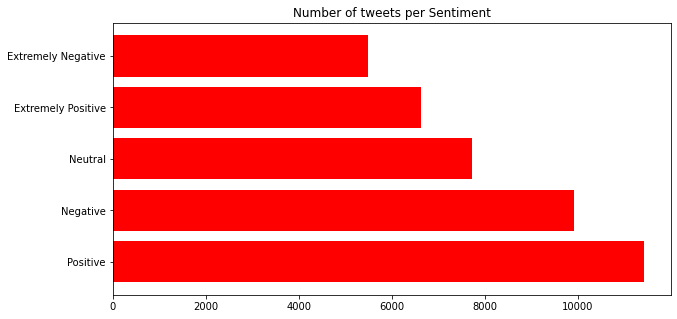

In [10]:
plt.figure(1, figsize=(10, 5))
plt.barh(df.Sentiment.value_counts().index, df.Sentiment.value_counts().values, 
        color = 'red')
plt.title("Number of tweets per Sentiment")
plt.show()

_The chart shows, that most of the tweets are positive. This may be correct, and eanglish speakers have good sentiments with the pandemic, or there is a bias in the tweet selection_

## EDA

In [11]:
# Length of tweets
df["Len_Tweet"] = [len(x) for x in df.OriginalTweet]
df.head()

,UserName,ScreenName,Location,OriginalTweet,Sentiment,Day,Month,Len_Tweet
0,3799,48751,London,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,16,3,111
1,3800,48752,UK,advice Talk to your neighbours family to excha...,Positive,16,3,237
2,3801,48753,Vagabonds,Coronavirus Australia: Woolworths to give elde...,Positive,16,3,131
3,3802,48754,NaN,My food stock is not the only one which is emp...,Positive,16,3,306
4,3803,48755,NaN,"Me, ready to go at supermarket during the #COV...",Extremely Negative,16,3,310


In [12]:
df.pivot_table(values="OriginalTweet", index = "Month", aggfunc="count")

,OriginalTweet
Month,
1,630
2,954
3,26309
4,2479
5,1131
6,1742
7,1843
8,1881
9,1471


In [13]:
df.pivot_table(values="OriginalTweet", index = "Sentiment", aggfunc="count")

,OriginalTweet
Sentiment,
Extremely Negative,5481
Extremely Positive,6624
Negative,9917
Neutral,7713
Positive,11422


In [14]:
df.describe()[:][["Day", "Month", "Len_Tweet"]]

,Day,Month,Len_Tweet
count,41157.000000,41157.000000,41157.000000
mean,15.080399,4.333673,204.200160
std,8.460537,2.488591,68.655129
min,4.000000,1.000000,11.000000
25%,4.000000,3.000000,151.000000
50%,18.000000,3.000000,215.000000
75%,22.000000,5.000000,259.000000
max,31.000000,12.000000,355.000000


_More than 75% of the tweets have a real length of characters, but there are some tweets that pass the number of chracters by tweet_

In [15]:
df[df["Len_Tweet"] > 280].iloc[0, 3]

"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j"

In [16]:
len("My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral")

282

_With the information above, we can see that the tweets have more characters because of \r or \n, also the tweet has a web page_

In [17]:
df.pivot_table(values="Len_Tweet", index = ["Sentiment"], aggfunc="median")

,Len_Tweet
Sentiment,
Extremely Negative,237
Extremely Positive,241
Negative,212
Neutral,160
Positive,218


_The extremely posivite and extremely negative tweets have more characters than any other tweet, so a large tweet may be a signal of and extremist tweet._

In [18]:
df.pivot_table(values="Len_Tweet", index = ["Sentiment"], columns= ["Month"], aggfunc="median")

Month,1,2,3,4,5,6,7,8,9,10,11,12
Sentiment,,,,,,,,,,,,
Extremely Negative,233.5,232.0,238.0,236.0,227.5,239.0,238.0,235.0,234.0,233.0,229.0,221.5
Extremely Positive,235.0,241.0,243.0,237.0,235.5,239.0,239.0,240.0,237.0,244.0,247.5,232.0
Negative,201.5,194.5,215.0,213.0,211.5,202.0,210.0,198.0,216.0,207.0,214.0,200.0
Neutral,168.0,158.0,160.0,160.0,151.0,167.0,168.5,157.0,141.0,154.0,165.0,160.0
Positive,227.5,225.0,218.0,211.5,224.5,213.0,219.0,217.0,226.0,215.0,207.0,211.0


## Preprocessing Tweets

In [19]:
sent_dic = dict(zip(df.Sentiment.unique(), range(len(df.Sentiment.unique()))))
df["Sent_Code"] = [sent_dic[x] for x in df.Sentiment]
Y = keras.utils.to_categorical(df.Sent_Code)

### Tokenizing the data

In [20]:
maxlen = 100 #max number of word
training_samples = 37157 #train in 200
validation_samples = 4000 # validates on 10000
max_words = 20000 #considers the first 10000 words

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.OriginalTweet)
sequences = tokenizer.texts_to_sequences(df.OriginalTweet)

In [21]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 85198 unique tokens.


In [22]:
labels = np.asarray(Y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (41157, 100)
Shape of label tensor: (41157, 5)


In [23]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

## Embedding

In [24]:
myfile9 = drive.CreateFile({'id': '1JT5s4yhAcSfGvgWVKf57QkoMTM72zrSF'})
myfile9.GetContentFile('glove.6B.100d.txt')

In [25]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Neural Network

In [27]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(GRU(64, dropout = 0.1, recurrent_dropout = 0.3, return_sequences = True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
gru (GRU)                    (None, 100, 64)           31872     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,067,141
Trainable params: 2,067,141
Non-trainable params: 0
______________________________________________

In [28]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/15
291/291 [==============================] - 88s 303ms/step - loss: 1.3612 - categorical_accuracy: 0.3987 - val_loss: 1.2092 - val_categorical_accuracy: 0.4710
Epoch 2/15
291/291 [==============================] - 88s 303ms/step - loss: 1.1689 - categorical_accuracy: 0.5031 - val_loss: 1.0690 - val_categorical_accuracy: 0.5458
Epoch 3/15
291/291 [==============================] - 88s 301ms/step - loss: 1.1055 - categorical_accuracy: 0.5348 - val_loss: 1.0275 - val_categorical_accuracy: 0.5692
Epoch 4/15
291/291 [==============================] - 88s 304ms/step - loss: 1.0520 - categorical_accuracy: 0.5664 - val_loss: 1.0009 - val_categorical_accuracy: 0.5757
Epoch 5/15
291/291 [==============================] - 89s 305ms/step - loss: 1.0086 - categorical_accuracy: 0.5886 - val_loss: 0.9452 - val_categorical_accuracy: 0.6133
Epoch 6/15
291/291 [==============================] - 89s 305ms/step - loss: 0.9697 - categorical_accuracy: 0.6083 - val_loss: 0.9004 - val_categorical_acc

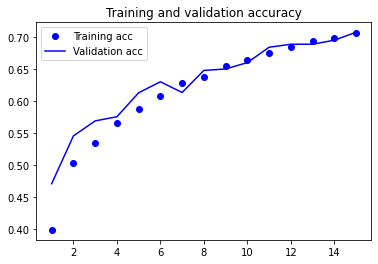

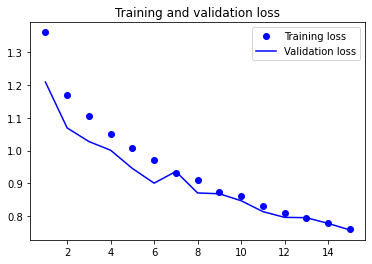

In [30]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Test

In [31]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

myfile3 = drive.CreateFile({'id': '1wQ-qDTT0vRE49ipbP0J1WbG-rHxV7A7c'})
myfile3.GetContentFile('Corona_NLP_test.csv')

In [32]:
df2 = pd.read_csv("Corona_NLP_test.csv")
df2.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


## Preprocessing Test

In [33]:
df2["Sent_Code"] = [sent_dic[x] for x in df2.Sentiment]
Y_test = keras.utils.to_categorical(df2.Sent_Code)

In [34]:
sequences2 = tokenizer.texts_to_sequences(df2.OriginalTweet)
data_test = pad_sequences(sequences2, maxlen=maxlen)

In [35]:
model.evaluate(data_test, Y_test)

119/119 [==============================] - 3s 27ms/step - loss: 0.8391 - categorical_accuracy: 0.6906


[0.8391098976135254, 0.6906266212463379]

_The model has a categorical acurracy of 71.4%, that is close to the acurracy of the validation set, so there is no overfitting between the validation and test. Next the construction of a confussion matrix to observe wich categorias have a problem._

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


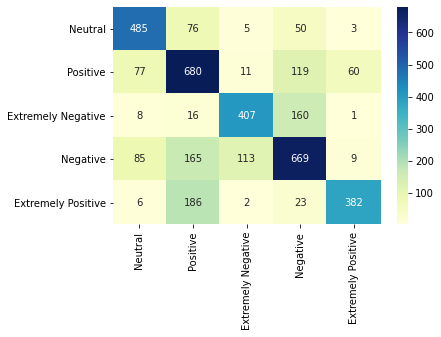

In [36]:
y_predict = model.predict_classes(data_test)
sent = ["Neutral", "Positive", "Extremely Negative", "Negative", "Extremely Positive"]

cm = confusion_matrix(df2.Sent_Code, y_predict)
heatmap(cm, cmap="YlGnBu", annot = True, fmt="d", xticklabels = sent, yticklabels = sent)

_As expected, the extremely positives tweets are confused with the positive tweets, this also occurs with the negative tweets. The next part will be joining this four categories into only two, this may help in the accuracy metric_

In [37]:
print(classification_report(df2.Sent_Code, y_predict))

              precision    recall  f1-score   support

           0       0.73      0.78      0.76       619
           1       0.61      0.72      0.66       947
           2       0.76      0.69      0.72       592
           3       0.66      0.64      0.65      1041
           4       0.84      0.64      0.72       599

    accuracy                           0.69      3798
   macro avg       0.72      0.69      0.70      3798
weighted avg       0.70      0.69      0.69      3798



# New Model

In [38]:
new_df = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin')
new_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [39]:
new_sentiments = []
for i in new_df.Sentiment:
  if i == "Extremely Negative":
    new_sentiments.append("Negative")
  elif i == "Extremely Positive":
    new_sentiments.append("Positive")
  else:
    new_sentiments.append(i)

new_df.Sentiment = np.array(new_sentiments)

## New Preprocessing

In [40]:
new_sent_dic = dict(zip(new_df.Sentiment.unique(), range(len(new_df.Sentiment.unique()))))
new_df["Sent_Code"] = [new_sent_dic[x] for x in new_df.Sentiment]
new_Y = keras.utils.to_categorical(new_df.Sent_Code)

## New Token

In [41]:
new_sequences = tokenizer.texts_to_sequences(new_df.OriginalTweet)
new_data = pad_sequences(new_sequences, maxlen=maxlen)

In [42]:
indices = np.arange(new_data.shape[0])
np.random.shuffle(indices)
new_data = new_data[indices]
new_labels = new_Y[indices]

x_train_n = new_data[:training_samples]
y_train_n = new_labels[:training_samples]
x_val_n = new_data[training_samples: training_samples + validation_samples]
y_val_n = new_labels[training_samples: training_samples + validation_samples]

## New Neural Network

In [43]:
model2 = Sequential()
model2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model2.add(GRU(128, dropout = 0.1, recurrent_dropout = 0.3, return_sequences = True))
model2.add(LSTM(64))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(.2))
model2.add(Dense(3, activation='softmax'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 128)          88320     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

In [44]:
model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history2 = model2.fit(x_train_n, y_train_n, epochs=20, batch_size=256, validation_data=(x_val_n, y_val_n))

Epoch 1/20
146/146 [==============================] - 46s 313ms/step - loss: 0.9005 - categorical_accuracy: 0.5771 - val_loss: 0.7959 - val_categorical_accuracy: 0.6618
Epoch 2/20
146/146 [==============================] - 45s 305ms/step - loss: 0.7574 - categorical_accuracy: 0.6735 - val_loss: 0.7551 - val_categorical_accuracy: 0.6710
Epoch 3/20
146/146 [==============================] - 45s 307ms/step - loss: 0.7150 - categorical_accuracy: 0.6976 - val_loss: 0.6986 - val_categorical_accuracy: 0.7070
Epoch 4/20
146/146 [==============================] - 45s 307ms/step - loss: 0.6729 - categorical_accuracy: 0.7201 - val_loss: 0.6597 - val_categorical_accuracy: 0.7327
Epoch 5/20
146/146 [==============================] - 45s 308ms/step - loss: 0.6387 - categorical_accuracy: 0.7408 - val_loss: 0.6427 - val_categorical_accuracy: 0.7450
Epoch 6/20
146/146 [==============================] - 45s 307ms/step - loss: 0.6178 - categorical_accuracy: 0.7507 - val_loss: 0.6048 - val_categorical_acc

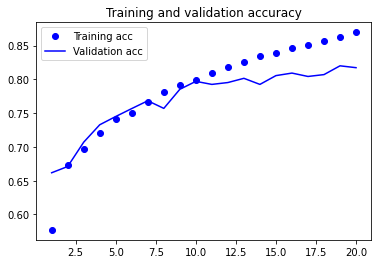

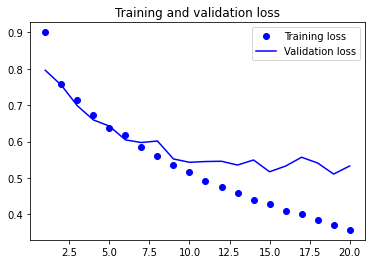

In [45]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

_There is an increment in the categorical acurracy for train and validation set, also a decrease is observed in the overfitting of the new model._

## New Test

In [46]:
df2_n = pd.read_csv("Corona_NLP_test.csv")
df2_n.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [47]:
new_sentiments_test = []
for i in df2_n.Sentiment:
  if i == "Extremely Negative":
    new_sentiments_test.append("Negative")
  elif i == "Extremely Positive":
    new_sentiments_test.append("Positive")
  else:
    new_sentiments_test.append(i)

df2_n.Sentiment = np.array(new_sentiments_test)

df2_n["Sent_Code"] = [new_sent_dic[x] for x in df2_n.Sentiment]
new_Y_test = keras.utils.to_categorical(df2_n.Sent_Code)

In [48]:
sequences2_n = tokenizer.texts_to_sequences(df2_n.OriginalTweet)
data_test_n = pad_sequences(sequences2_n, maxlen=maxlen)

In [49]:
model2.evaluate(data_test_n, new_Y_test)

119/119 [==============================] - 3s 26ms/step - loss: 0.5359 - categorical_accuracy: 0.8133


[0.5358721613883972, 0.8133227825164795]

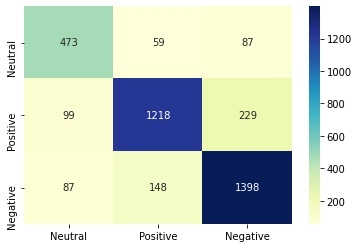

In [50]:
y_predict_n = model2.predict_classes(data_test_n)
sent2 = ["Neutral", "Positive", "Negative"]

cm_n = confusion_matrix(df2_n.Sent_Code, y_predict_n)
heatmap(cm_n, cmap="YlGnBu", annot = True, fmt="d", xticklabels = sent2, yticklabels = sent2)

In [51]:
print(classification_report(df2_n.Sent_Code, y_predict_n))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       619
           1       0.85      0.79      0.82      1546
           2       0.82      0.86      0.84      1633

    accuracy                           0.81      3798
   macro avg       0.80      0.80      0.80      3798
weighted avg       0.82      0.81      0.81      3798



_We can observe an increase in the classification metrics, with an exception in the neutral category, this category has a 10% decrease in the f1-score campared to thw other two categories. In the next model the neutral category and the stop words will be eliminated to see if the score will increase_

## Final Model

In [52]:
f_df = pd.read_csv('Corona_NLP_train.csv', encoding = 'latin')
# No neutrals
f_df = f_df[f_df['Sentiment'] != 'Neutral']
f_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive


## Final Sentiments

In [53]:
f_sentiments = []
for i in f_df.Sentiment:
  if i == "Extremely Negative":
    f_sentiments.append("Negative")
  elif i == "Extremely Positive":
    f_sentiments.append("Positive")
  else:
    f_sentiments.append(i)

f_df.Sentiment = np.array(f_sentiments)

In [54]:
f_df.Sentiment.value_counts()

Positive    18046
Negative    15398
Name: Sentiment, dtype: int64

## New Preprocessing

In [55]:
# Text cleansing
clean_t = []

# iteration in text
for text in f_df['OriginalTweet']:
    aux1 = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    aux2 = re.sub("[^a-zA-Z0-9 ]", " ", aux1.decode("utf-8"), flags=re.UNICODE)
    aux3 = u' '.join(aux2.lower().split())
    clean_t.append(aux3)

In [56]:
# separation of every word in phrase
clean_t_2 = []
for frase in clean_t:
    clean_t_2.append(frase.split(' '))

In [57]:
# stop words
stop = stopwords.words('english')
clean_f = []
for frase in clean_t_2:
    aux = []
    for w in frase:
        if w not in stop:
            aux.append(w)
    clean_f.append(aux)

In [58]:
# New clean tweet
f_df['OriginalTweet'] = [" ".join(x) for x in clean_f]

In [59]:
f_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,Positive
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,Positive
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,Positive
4,3803,48755,NaN,16-03-2020,ready go supermarket covid19 outbreak paranoid...,Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,news regionas first confirmed covid 19 case ca...,Positive


In [60]:
# Sentiment dictionary

f_sent_dic = dict(zip(f_df.Sentiment.unique(), range(len(f_df.Sentiment.unique()))))
f_df["Sent_Code"] = [f_sent_dic[x] for x in f_df.Sentiment]
f_Y = keras.utils.to_categorical(f_df.Sent_Code)

In [61]:
f_df.shape

(33444, 7)

In [62]:
maxlen = 100 #max number of word
training_samples = 30100 #train in 200
validation_samples = 3344 # validates on 10000
max_words = 20000 #considers the first 10000 words

tokenizer3 = Tokenizer(num_words=max_words)
tokenizer3.fit_on_texts(f_df.OriginalTweet)
sequences = tokenizer3.texts_to_sequences(f_df.OriginalTweet)

In [63]:
word_index = tokenizer3.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen)

Found 68135 unique tokens.


In [64]:
labels = np.asarray(f_Y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (33444, 100)
Shape of label tensor: (33444, 2)


In [65]:
# shuffle
f_indices = np.arange(data.shape[0])
np.random.shuffle(f_indices)
data = data[f_indices]
labels = labels[f_indices]

f_x_train = data[:training_samples]
f_y_train = labels[:training_samples]
f_x_val = data[training_samples: training_samples + validation_samples]
f_y_val = labels[training_samples: training_samples + validation_samples]

# Embedding

In [66]:
myfile9 = drive.CreateFile({'id': '1JT5s4yhAcSfGvgWVKf57QkoMTM72zrSF'})
myfile9.GetContentFile('glove.6B.100d.txt')

In [67]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [68]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

## Neural Network

In [69]:
embedding_dim = 100
model3 = Sequential()
model3.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model3.add(GRU(64, dropout = 0.1, recurrent_dropout = 0.3, return_sequences = True))
model3.add(LSTM(64))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(.2))
model3.add(Dense(2, activation='sigmoid'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2000000   
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 64)           31872     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 66        
Total params: 2,067,042
Trainable params: 2,067,042
Non-trainable params: 0
____________________________________________

In [70]:
model3.layers[0].set_weights([embedding_matrix])
model3.layers[0].trainable = False

In [71]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history3 = model3.fit(f_x_train, f_y_train, epochs=15, batch_size=128, validation_data=(f_x_val, f_y_val))

Epoch 1/15
236/236 [==============================] - 72s 303ms/step - loss: 0.5514 - categorical_accuracy: 0.7183 - val_loss: 0.4840 - val_categorical_accuracy: 0.7664
Epoch 2/15
236/236 [==============================] - 69s 294ms/step - loss: 0.4553 - categorical_accuracy: 0.7884 - val_loss: 0.4358 - val_categorical_accuracy: 0.7975
Epoch 3/15
236/236 [==============================] - 69s 291ms/step - loss: 0.4218 - categorical_accuracy: 0.8068 - val_loss: 0.4152 - val_categorical_accuracy: 0.8104
Epoch 4/15
236/236 [==============================] - 69s 294ms/step - loss: 0.4046 - categorical_accuracy: 0.8201 - val_loss: 0.4098 - val_categorical_accuracy: 0.8113
Epoch 5/15
236/236 [==============================] - 71s 299ms/step - loss: 0.3819 - categorical_accuracy: 0.8297 - val_loss: 0.4189 - val_categorical_accuracy: 0.8020
Epoch 6/15
236/236 [==============================] - 69s 292ms/step - loss: 0.3666 - categorical_accuracy: 0.8371 - val_loss: 0.3828 - val_categorical_acc

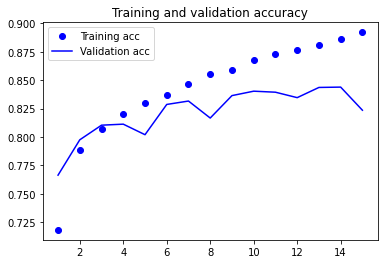

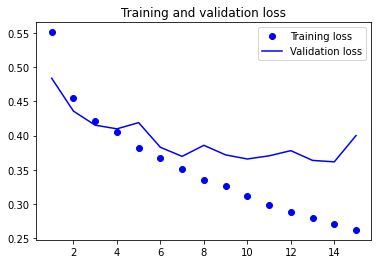

In [72]:
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Final Test

In [73]:
df2_n = pd.read_csv("Corona_NLP_test.csv")
df2_n = df2_n[df2_n['Sentiment'] != 'Neutral']
df2_n.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive


## Final Preprocessing

In [74]:
new_sentiments_test = []
for i in df2_n.Sentiment:
  if i == "Extremely Negative":
    new_sentiments_test.append("Negative")
  elif i == "Extremely Positive":
    new_sentiments_test.append("Positive")
  else:
    new_sentiments_test.append(i)

df2_n.Sentiment = np.array(new_sentiments_test)

df2_n["Sent_Code"] = [f_sent_dic[x] for x in df2_n.Sentiment]
new_Y_test = keras.utils.to_categorical(df2_n.Sent_Code)

In [75]:
# Text cleansing
clean2_t = []

# iteration in text
for text in df2_n['OriginalTweet']:
    aux1 = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    aux2 = re.sub("[^a-zA-Z0-9 ]", " ", aux1.decode("utf-8"), flags=re.UNICODE)
    aux3 = u' '.join(aux2.lower().split())
    clean2_t.append(aux3)

In [76]:
# separation of every word in phrase
clean2_t_2 = []
for frase in clean2_t:
    clean2_t_2.append(frase.split(' '))

In [77]:
# stop words
stop = stopwords.words('english')
clean2_f = []
for frase in clean2_t_2:
    aux = []
    for w in frase:
        if w not in stop:
            aux.append(w)
    clean2_f.append(aux)

In [78]:
# New clean tweet
df2_n['OriginalTweet'] = [" ".join(x) for x in clean2_f]

In [79]:
sequences2_n_f = tokenizer3.texts_to_sequences(df2_n.OriginalTweet)
data_test_n_f = pad_sequences(sequences2_n_f, maxlen=maxlen)

In [80]:
model3.evaluate(data_test_n_f, new_Y_test)

100/100 [==============================] - 3s 31ms/step - loss: 0.4084 - categorical_accuracy: 0.8235


[0.4083879292011261, 0.8235294222831726]

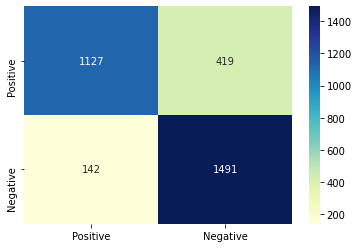

In [81]:
y_predict_n_f = model3.predict_classes(data_test_n_f)
sent2_f = ["Positive", "Negative"]

cm_n_f = confusion_matrix(df2_n.Sent_Code, y_predict_n_f)
heatmap(cm_n_f, cmap="YlGnBu", annot = True, fmt="d", xticklabels = sent2_f, yticklabels = sent2_f)

In [82]:
print(classification_report(df2_n.Sent_Code, y_predict_n_f))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1546
           1       0.78      0.91      0.84      1633

    accuracy                           0.82      3179
   macro avg       0.83      0.82      0.82      3179
weighted avg       0.83      0.82      0.82      3179



In [96]:
df_show = pd.read_csv('Corona_NLP_test.csv')
df_show = df_show[df_show['Sentiment'] != 'Neutral']

dict_change = dict(zip(f_sent_dic.values(), f_sent_dic.keys()))
df_show['Predict'] = [dict_change[x] for x in y_predict_n_f]

In [122]:
id_2 = np.random.randint(0, df_show.shape[0])
print(df_show.iloc[id_2, 4])
print(df_show.iloc[id_2, -1])


#coronavirusaustralia #Covid_19 #COVID?19 #dogs #aupol #MSM  # ridiculous
Negative
